# Imports & Setup

In [23]:
# !pip install ydata-profiling
# !pip install ipywidgets # needed for ProfileReport

In [68]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import gc
from time import perf_counter 
from tqdm import tqdm

import string
import re

import itertools
from itertools import permutations, product, combinations
from functools import reduce

import re
import nltk.corpus
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import digits

# Machine learning packages
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer 
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

# Optional
# from ydata_profiling import ProfileReport
# import ipywidgets

## Load Data

In [3]:
train = pd.read_csv('data/BBC News Train.csv')
test = pd.read_csv('data/BBC News Test.csv')
sample_solution = pd.read_csv("data/BBC News Sample Solution.csv")

## Profile Report - Optional

In [4]:
# profile = ProfileReport(train, title="Test Profiling Report") #, explorative=True)
# profile.to_notebook_iframe()
# profile.to_file("test_profile.html")

# EDA
- Visualize the raw data of the training set by:
    - Viewing the individual records
    - View the information about the dataset
    - Creating a histogram to visualize the data
    - Develop a conclusion about the data

- Findings from below:
    - There are 1490 news grouped into 5 topics
    - There are no null/nan/missing values
    - Classes are relatively balanced. 
    - The most common and least common topics are sports and entertainment respectively.
    - There are 50 non-unique articles from `train.nunique()`
    - After tokenizing the document, the maximum, minimum, and average amount of words in each article are (1698, 48, 219.71744966442952)

In [5]:
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [7]:
train.nunique()

ArticleId    1490
Text         1440
Category        5
dtype: int64

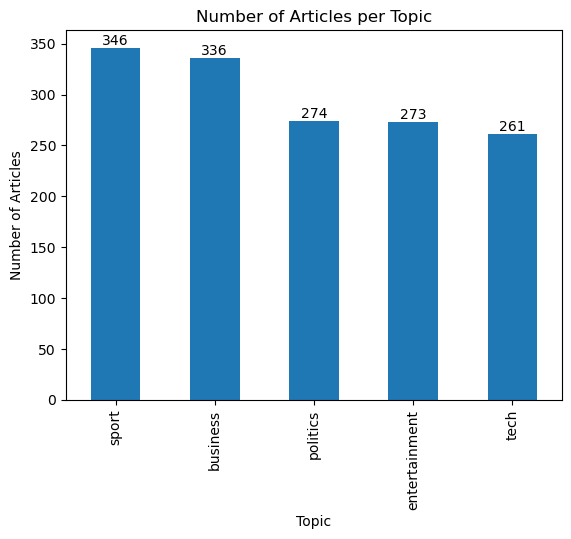

In [8]:
train['Category'].value_counts().plot(kind='bar')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.title('Number of Articles per Topic')

plt.xticks(rotation=90)

for i, v in enumerate(train['Category'].value_counts()):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

Tokenize

In [9]:
stop_words = stopwords.words('english')
train['Text'] = train['Text'].apply(lambda row: re.sub(r'[^\w\s]+', '', row))
train['Text'] = train['Text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
train['Text'] = train['Text'].apply(lambda x: re.sub(' +', ' ', x))

X_train, X_valid, y_train, y_valid = train_test_split(train['Text'], train['Category'], test_size=0.33, random_state=42)

In [10]:
nltk.download('punkt')

dataframe = pd.DataFrame()

dataframe['tokenized'] = train.apply(lambda row: nltk.word_tokenize(row['Text']), axis=1)
dataframe['num_words'] = dataframe['tokenized'].apply(lambda lst: len(lst))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/devinlynch/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tokenized  1490 non-null   object
 1   num_words  1490 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


In [12]:
max_words = dataframe['num_words'].max()
min_words = dataframe['num_words'].min()
avg_words = dataframe['num_words'].mean()

max_words, min_words, avg_words

(1698, 48, 219.71744966442952)

- Create the datasets using tfidf to train the NMF model

In [15]:
def tfidf(X_train, X_valid):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english", lowercase = True)
    tfidf_vectorizer.fit(X_train)
    tfidf_train = tfidf_vectorizer.transform(X_train)
    tfidf_valid = tfidf_vectorizer.transform(X_valid)
    tokens = tfidf_vectorizer.get_feature_names_out()
    train_vect = pd.DataFrame(data = tfidf_train.toarray(),columns = tokens)
    valid_vect = pd.DataFrame(data = tfidf_valid.toarray(),columns = tokens)
    return tfidf_train, tfidf_valid, train_vect, valid_vect

In [21]:
tfidf_train, tfidf_valid, train_vect, valid_vect = tfidf(X_train, X_valid)

# Model Construction
Use [`sklearn.decomposition.NMF`]('https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html') to construct an NMF model. 

First initialize the model:

In [16]:
def model(beta_loss, solver):
    nmf = NMF(
        init='nndsvdar', # Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparseness)
        # n_components=5, 
        n_components='auto',
        solver=solver,
        random_state=1,
        beta_loss=beta_loss,
        alpha_W=0.00005,
        alpha_H=0.00005,
        l1_ratio=.1,
    )
    return nmf

Create a predict method:

In [17]:
def predict(matrix):
    sortedMatrix = np.argsort(matrix)
    n_predictions, maxValue = sortedMatrix.shape
    
    predictions = [[sortedMatrix[i][maxValue - 1]] for i in range(n_predictions)]
    topics = np.empty(n_predictions, dtype = np.int64)
    
    for i in range(n_predictions):
        topics[i] = predictions[i][0]
    return topics

Calculate the accuracy based on the best permutation of categories:

In [74]:
def label_permute(ytdf, yp, perm_list, n=5):
    """
    ytdf: labels dataframe object
    yp: clustering label prediction output
    Returns permuted label order and accuracy. 
    Example output: (3, 4, 1, 2, 0), 0.74 
    """
    unique = np.unique(ytdf)
    perm = itertools.permutations(perm_list)
    accuracyMatrix = []
    for i in list(perm):
        j = 0
        ytdf_guess = ytdf
        for k in unique:
            ytdf_guess = np.where(ytdf_guess == k, i[j], ytdf_guess)
            j+=1
        pred = ytdf_guess.tolist()

        accuracy = accuracy_score(pred,yp)
        accuracyMatrix.append((i,accuracy))
    i = 0
    maxAccuracy = 0
    while i < len(accuracyMatrix):
        if accuracyMatrix[i][1] > maxAccuracy:
            maxtuple = accuracyMatrix[i]
            maxAccuracy = accuracyMatrix[i][1]
        i += 1
    
    # print(maxtuple)
    return maxtuple

In [34]:
labels = [0,1,2,3,4]

Predict using the Frobenius loss function:

In [66]:
# Training Data

m = model("frobenius", "cd").fit(tfidf_train)
print(f'Model: {m}')

yhat_fb_train = predict(m.transform(tfidf_train))
label_order, accuracy = label_permute(y_train, yhat_fb_train,labels)

print(label_order)
print(accuracy)

Model: NMF(alpha_H=5e-05, alpha_W=5e-05, init='nndsvdar', l1_ratio=0.1, n_components=5,
    random_state=1)
((4, 3, 1, 0, 2), 0.8907815631262525)
(4, 3, 1, 0, 2)
0.8907815631262525


In [67]:
# Validation data 

m = model("frobenius", "cd").fit(tfidf_train)
print(f'Model: {m}')
yhat_fb_valid = predict(m.transform(tfidf_valid))
label_order, accuracy = label_permute(y_valid, yhat_fb_valid,labels)

print(label_order)
print(accuracy)

Model: NMF(alpha_H=5e-05, alpha_W=5e-05, init='nndsvdar', l1_ratio=0.1, n_components=5,
    random_state=1)
((4, 3, 1, 0, 2), 0.9105691056910569)
(4, 3, 1, 0, 2)
0.9105691056910569


Predict using the Kullback-Leibler loss function
- `mu` is the only solver compatible with KL

In [64]:
# Training data

m = model("kullback-leibler", "mu").fit(tfidf_train)
print(f'trying with {m}')

yhat_kl_train = predict(m.transform(tfidf_train))
label_order, accuracy = label_permute(y_train, yhat_kl_train,labels)

print(label_order)
print(accuracy)

trying with NMF(alpha_H=5e-05, alpha_W=5e-05, beta_loss='kullback-leibler', init='nndsvdar',
    l1_ratio=0.1, n_components=5, random_state=1, solver='mu')
((4, 3, 1, 0, 2), 0.9478957915831663)
(4, 3, 1, 0, 2)
0.9478957915831663


In [65]:
# Validation data

m = model("kullback-leibler", "mu").fit(tfidf_train)
print(f'trying with {m}')

yhat_kb_valid = predict(m.transform(tfidf_valid))
label_order, accuracy = label_permute(y_valid, yhat_kb_valid, labels)

print(label_order)
print(accuracy)

trying with NMF(alpha_H=5e-05, alpha_W=5e-05, beta_loss='kullback-leibler', init='nndsvdar',
    l1_ratio=0.1, n_components=5, random_state=1, solver='mu')
((4, 3, 1, 0, 2), 0.9613821138211383)
(4, 3, 1, 0, 2)
0.9613821138211383


# Unsupervised Learning Comparision: K-Means

In [76]:
km = KMeans(n_clusters=5, n_init=10) # changed to 10 from auto to avoid warning (default is 10)
km.fit(tfidf_train)
yhat = km.predict(tfidf_valid)
labelorder, acc = label_permute(y_valid, yhat,labels)
print(acc)

0.8150406504065041


# Supervised Learning Comparison: Gradient Boosting